In [1]:
import numpy as np
import math as m
import cython
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
#generate paths for price
start_time = time.time()
np.random.seed(1)
def simulate_stocks(S0, r,sigma,steps,T, nSims, div):
    sim_steps = steps*T+1
    dt = 1/steps
    mu = (r-div-0.5*sigma*sigma)*dt
    sigma = sigma*m.sqrt(dt)
    St = np.zeros(shape=(sim_steps,nSims))
    St[0,] = S0
    for i in range(1,sim_steps):
            for j in range(0,nSims):
                e = np.random.randn(1)
                St[i,j] = St[i-1,j]*m.exp(mu+sigma*e)
    return(St)

In [3]:
#input 
nSims=2000
S0=100
sigma=0.2
K=100
r=0.03
T=1
steps=252
div=0

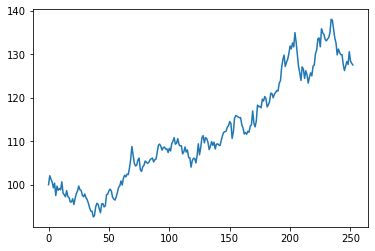

In [4]:
#generate the realized stock price
real_stock = simulate_stocks(S0,r,sigma,steps,T,1,div)
plt.plot(real_stock)

In [5]:
simulate_stocks = np.vectorize(simulate_stocks)
sim_stocks = simulate_stocks(S0,r,sigma,steps,T,nSims,div)
print("The normal numpy execution with vectorization takes {0} seconds ".format(time.time() - start_time))

The normal numpy execution with vectorization takes 3.3962395191192627 seconds 


In [6]:
sim_stocks_data = pd.DataFrame(sim_stocks)

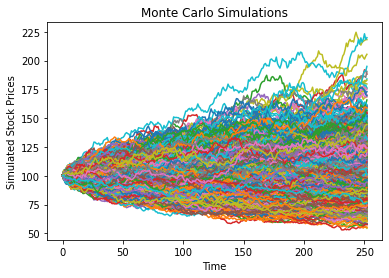

In [43]:
import matplotlib.pyplot as plt
plt.plot(sim_stocks_data)
plt.title("Monte Carlo Simulations")
plt.xlabel("Time")
plt.ylabel("Simulated Stock Prices")
plt.show()

In [8]:
#get an array containing the end of month date
days = []
for i in range(0, len(sim_stocks), 21):
    day = i
    days.append(day)    

In [9]:
#calculate the arithmetic mean price
mean_prices = []
for i in days:
    price = sim_stocks_data.iloc[i,:]
    mean_price = np.mean(price)
    mean_prices.append(mean_price)
mean_prices
final_mean = np.mean(mean_prices)
final_mean

101.71299083164459

In [10]:
#return final Asian option price
opt_price = max(final_mean-K,0)*m.exp(-r*T)

In [11]:
#create data frame
data = pd.DataFrame(np.zeros(len(real_stock)).astype('str'), columns=['Realized Stock Price'])
data.loc[:,'Strike Price'] = K
data.loc[:,'Time to Maturity'] = 0
data.loc[:,'Option Price'] = 0.0
data.loc[:,'Delta'] = 0.0
data.loc[:,'Gamma'] = 0.0
data.loc[:,'Option daily PnL'] = 0.0
data.loc[:,'Delta Hedge Portfolio'] = 0.0
data.loc[:,'Delta Hedge daily PnL'] = 0.0
data.loc[:,'Portfolio daily PnL'] = 0.0

In [12]:
#get stock price
data['Realized Stock Price'] = real_stock

In [13]:
#get time to maturity
times = []
for i in range(0, len(real_stock)):
    time = ((T*steps)-i)/(steps)
    times.append(time)

In [14]:
data['Time to Maturity'] = times

In [15]:
def simulate_stocks(S0, r,sigma,steps,T, nSims, div):
    sim_steps = int(steps*T)+1
    dt = 1/steps
    mu = (r-div-0.5*sigma*sigma)*dt
    sigma = sigma*m.sqrt(dt)
    St = np.zeros(shape=(sim_steps,nSims))
    St[0,] = S0
    for i in range(1,sim_steps):
            for j in range(0,nSims):
                e = np.random.randn(1)
                St[i,j] = St[i-1,j]*m.exp(mu+sigma*e)
    return(St)

In [16]:
simulate_stocks = np.vectorize(simulate_stocks)

In [17]:
final_option_prices = []
final_option_prices_down = []
final_option_prices_up = []
#Generate new mean price
for i in range(0, len(real_stock)):
    S0 = data['Realized Stock Price'][i]
    T = data['Time to Maturity'][i]
    sim_stocks_2 = simulate_stocks(S0,r,sigma,steps,T,nSims,div)
    sim_stocks_data_2 = pd.DataFrame(sim_stocks_2)
    
    #calculate the arithmetic mean price
    option_prices = []
    for k in range(0, nSims):
        tmp_list = data.loc[0:i-1, 'Realized Stock Price'].tolist()
        tmp_list.extend(sim_stocks_data_2.iloc[:,k])
        prices_stock = []
        for n in days:
            price_stock = tmp_list[n]
            prices_stock.append(price_stock)
        mean_price = np.mean(prices_stock)
        option_price = max(mean_price-K,0)*m.exp(-r*T) #option price for 1 sim
        option_prices.append(option_price)
    final_option_price = np.mean(option_prices)
    final_option_prices.append(final_option_price)
    
    
    #P_up
    S0_up = data['Realized Stock Price'][i]*1.01
    sim_stocks_2_up = simulate_stocks(S0_up,r,sigma,steps,T,nSims,div)
    sim_stocks_data_2_up = pd.DataFrame(sim_stocks_2_up)
    
    #calculate the arithmetic mean price
    option_prices_up = []
    for kup in range(0, nSims):
        tmp_list_up = data.loc[0:i-1, 'Realized Stock Price'].tolist()
        tmp_list_up.extend(sim_stocks_data_2_up.iloc[:,kup])
        prices_stock_up = []
        for nup in days:
            price_stock_up = tmp_list_up[nup]
            prices_stock_up.append(price_stock_up)
        mean_price_up = np.mean(prices_stock_up)
        option_price_up = max(mean_price_up-K,0)*m.exp(-r*T) #option price for 1 sim
        option_prices_up.append(option_price_up)
    final_option_price_up = np.mean(option_prices_up)
    final_option_prices_up.append(final_option_price_up)   
    
    
    #P_down
    S0_down = data['Realized Stock Price'][i]*0.99
    sim_stocks_2_down = simulate_stocks(S0_down,r,sigma,steps,T,nSims,div)
    sim_stocks_data_2_down = pd.DataFrame(sim_stocks_2_down)
    
    #calculate the arithmetic mean price
    option_prices_down = []
    for kdown in range(0, nSims):
        tmp_list_down = data.loc[0:i-1, 'Realized Stock Price'].tolist()
        tmp_list_down.extend(sim_stocks_data_2_down.iloc[:,kdown])
        prices_stock_down = []
        for ndown in days:
            price_stock_down = tmp_list_down[ndown]
            prices_stock_down.append(price_stock_down)
        mean_price_down = np.mean(prices_stock_down)
        option_price_down = max(mean_price_down-K,0)*m.exp(-r*T) #option price for 1 sim
        option_prices_down.append(option_price_down)
    final_option_price_down = np.mean(option_prices_down)
    final_option_prices_down.append(final_option_price_down)   

In [18]:
data['Option Price'] = final_option_prices

In [19]:
deltas = []
gammas = []
for i in range(0, len(final_option_prices)):
    delta = (final_option_prices_up[i]-final_option_prices_down[i])/(2*0.01*(data['Realized Stock Price'][i]))    #shock = 0.01
    gamma = (final_option_prices_up[i] - (2*data['Option Price'][i]) + final_option_prices_down[i])/(0.01*0.01*(data['Realized Stock Price'][i])**2)      #shock = 0.01
    deltas.append(delta)
    gammas.append(gamma)

In [20]:
data['Delta'] = deltas
data['Gamma'] = gammas

In [21]:
for i in range(1, len(data)):
    data['Option daily PnL'][i] = (data['Option Price'][i] - data['Option Price'][i-1])

<ipython-input-21-3a2d03c0dac7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Option daily PnL'][i] = (data['Option Price'][i] - data['Option Price'][i-1])


In [22]:
for i in range(0, len(data)):
    data['Delta Hedge Portfolio'][i] = -data['Realized Stock Price'][i]*data['Delta'][i]

<ipython-input-22-95773b9d78a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Delta Hedge Portfolio'][i] = -data['Realized Stock Price'][i]*data['Delta'][i]


In [23]:
for i in range(1, len(data)):
    data['Delta Hedge daily PnL'][i] = (-data['Realized Stock Price'][i]*data['Delta'][i-1]) - data['Delta Hedge Portfolio'][i-1]

<ipython-input-23-eaa1602a4f2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Delta Hedge daily PnL'][i] = (-data['Realized Stock Price'][i]*data['Delta'][i-1]) - data['Delta Hedge Portfolio'][i-1]


In [24]:
for i in range(1, len(data)):
    data['Portfolio daily PnL'][i] = data['Option daily PnL'][i] + data['Delta Hedge daily PnL'][i]

<ipython-input-24-647b63f8c630>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Portfolio daily PnL'][i] = data['Option daily PnL'][i] + data['Delta Hedge daily PnL'][i]


In [25]:
total_PnL = np.sum(data['Portfolio daily PnL'])
print(total_PnL)

-2.47588585876165


In [26]:
pd.set_option('display.max_rows', None)
data

,Realized Stock Price,Strike Price,Time to Maturity,Option Price,Delta,Gamma,Option daily PnL,Delta Hedge Portfolio,Delta Hedge daily PnL,Portfolio daily PnL
0,100.000000,100,1.000000,5.004295,0.627313,2.788995e-01,0.000000,-62.731337,0.000000,0.000000
1,102.071617,100,0.996032,6.063554,0.618179,1.420825e-01,1.059259,-63.098487,-1.299553,-0.240295
2,101.291953,100,0.992063,6.004815,0.561274,-1.234135e-01,-0.058738,-56.852529,0.481972,0.423233
3,100.624153,100,0.988095,5.488224,0.521879,2.141396e-01,-0.516591,-52.513623,0.374819,-0.141772
4,99.276994,100,0.984127,4.794865,0.605849,7.079042e-02,-0.693359,-60.146885,0.703054,0.009694
5,100.369328,100,0.980159,5.540179,0.518326,-3.236440e-01,0.745314,-52.023985,-0.661789,0.083525
6,97.504612,100,0.976190,3.789600,0.506631,-5.501154e-02,-1.750579,-49.398820,1.484855,-0.265724
7,99.675701,100,0.972222,4.712106,0.373434,5.800564e-02,0.922506,-37.222292,-1.099940,-0.177434
8,98.728267,100,0.968254,4.213554,0.419797,9.685188e-02,-0.498552,-41.445783,0.353804,-0.144748
9,99.129839,100,0.964286,4.395517,0.542334,3.197538e-01,0.181963,-53.761447,-0.168579,0.013384


In [44]:
data.drop('Gamma', inplace=True, axis=1)
data

,Realized Stock Price,Strike Price,Time to Maturity,Option Price,Delta,Option daily PnL,Delta Hedge Portfolio,Delta Hedge daily PnL,Portfolio daily PnL
0,100.000000,100,1.000000,5.004295,0.627313,0.000000,-62.731337,0.000000,0.000000
1,102.071617,100,0.996032,6.063554,0.618179,1.059259,-63.098487,-1.299553,-0.240295
2,101.291953,100,0.992063,6.004815,0.561274,-0.058738,-56.852529,0.481972,0.423233
3,100.624153,100,0.988095,5.488224,0.521879,-0.516591,-52.513623,0.374819,-0.141772
4,99.276994,100,0.984127,4.794865,0.605849,-0.693359,-60.146885,0.703054,0.009694
5,100.369328,100,0.980159,5.540179,0.518326,0.745314,-52.023985,-0.661789,0.083525
6,97.504612,100,0.976190,3.789600,0.506631,-1.750579,-49.398820,1.484855,-0.265724
7,99.675701,100,0.972222,4.712106,0.373434,0.922506,-37.222292,-1.099940,-0.177434
8,98.728267,100,0.968254,4.213554,0.419797,-0.498552,-41.445783,0.353804,-0.144748
9,99.129839,100,0.964286,4.395517,0.542334,0.181963,-53.761447,-0.168579,0.013384


Text(0, 0.5, 'Price')

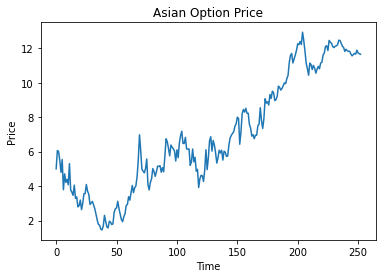

In [38]:
import matplotlib.pyplot as plt 
plt.plot(data['Option Price'])
plt.title("Asian Option Price")
plt.xlabel("Time")
plt.ylabel("Price")

Text(0, 0.5, 'Price')

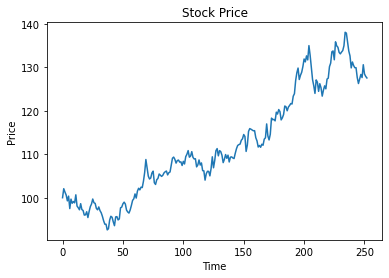

In [37]:
plt.plot(data['Realized Stock Price'])
plt.title("Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")

Text(0, 0.5, 'Value')

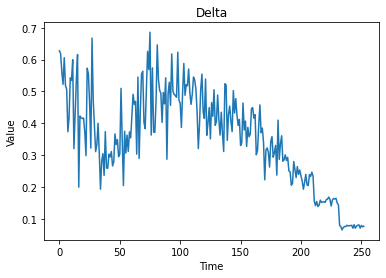

In [39]:
plt.plot(data['Delta'])
plt.title("Delta")
plt.xlabel("Time")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

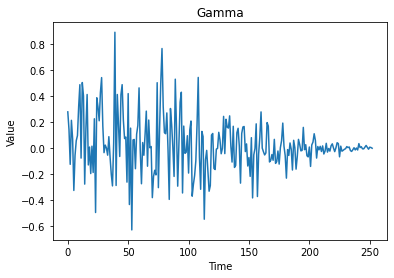

In [42]:
plt.plot(data['Gamma'])
plt.title("Gamma")
plt.xlabel("Time")
plt.ylabel("Value")

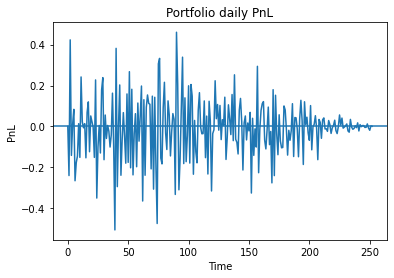

In [41]:
plt.plot(data['Portfolio daily PnL'])
plt.title("Portfolio daily PnL")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.axhline(y=0, xmin=0, xmax=1)